# 5. Machine Learning Models for TLC Prediction

In [4]:
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions, rdmolops
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs

## 5.1 Feature Selection and Preparation

In [5]:
def create_fingerprints(df: pd.DataFrame, column_name: str):
    """Function that creates Morgan Fingerprint, MACCS Fingerprints and RDKit Fingerprints for the extracted product molecules in the dataframe.

    Args:
        df (pd.DataFrame): dataframe containing the cleaned and extracted product SMILES
        column_name (str): column name of the SMILES column to be converted
    """
    radius = 2 # Radius of the fingerprint
    n_bits_morgan = 2048 # Fingerprint length
    n_bits_rdkit = 2048
    
    
    def safe_morgan(x):
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_morgan, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_morgan, dtype=int)
        else:
            arr = np.zeros((2048,), dtype=int)
            morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits_morgan)
            DataStructs.ConvertToNumpyArray(morgan, arr) #wichtig, no return sondern arr wird ueberschrieben, deshalb return arr
            return arr
    
    def safe_rdkit(x):
        arr = np.zeros((2048,), dtype=int)
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_rdkit, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_rdkit, dtype=int)
        return Chem.RDKFingerprint(mol, maxPath=5, fpSize=n_bits_rdkit)
    
    df_new = df.copy()
    df_new[column_name + '_Morgan_Fingerprint_np'] = df[column_name].apply(safe_morgan)
    df_new[column_name +'_RDKit_Fingerprint'] = df[column_name].apply(safe_rdkit)
    
    return df_new

In [16]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp.shape

(15063, 17)

In [17]:
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_fp['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [18]:
df_fp = create_fingerprints(df_fp, 'productSmiles_processed')
df_fp = create_fingerprints(df_fp, 'Solvent_A_Smiles')
df_fp = create_fingerprints(df_fp, 'Solvent_B_Smiles')
# convert the percent values to numpy arrays
df_fp['Percent_A'] = df_fp['Percent_A'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
df_fp['Percent_B'] = df_fp['Percent_B'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))
df_fp.head(5)

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,...,Solvent_A_Smiles,Solvent_B_Smiles,extracted_pr_Smiles,productSmiles_processed,productSmiles_processed_Morgan_Fingerprint_np,productSmiles_processed_RDKit_Fingerprint,Solvent_A_Smiles_Morgan_Fingerprint_np,Solvent_A_Smiles_RDKit_Fingerprint,Solvent_B_Smiles_Morgan_Fingerprint_np,Solvent_B_Smiles_RDKit_Fingerprint
0,2,A solution of 4-{[(phenylmethoxy)carbonylamino...,[C:1]1([CH2:7][O:8][C:9]([NH:11][CH2:12][C:13]...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],Preparation of N-methoxy-N-methyl(4-{[(phenylm...,[0.3],petroleum ether (2-methylpentane),EtOAc,[50.0],[50.0],...,CCCC(C)C,O=C(OCC)C,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,Putative nitrilase up-mutants were assayed in ...,[CH3:1][C:2]1(C)S[C@@H]2[C@H](NC([C@H](N)C3C=C...,['N#CC[C@@H](O)CC(=O)O'],NaN,[0.5],EtOAc,Hexane,[50.0],[50.0],...,O=C(OCC)C,CCCCCC,['N#CC[C@@H](O)CC(=O)O'],N#CC[C@@H](O)CC(=O)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,To 0.4 g N6-benzoyl-3′-O-(methylthiomethyl)-5′...,[C:1]([NH:9][C:10]1[C:11]2[N:12]=[CH:13][N:14]...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,NaN,[0.3],EtOAc,Hexane,[70.0],[30.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cccc...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6,3.5 g N4-benzoyl-5′-O-tert-butyldimethylsilyl-...,[C:1]([NH:9][C:10]1[CH:30]=[CH:29][N:13]([C@@H...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,NaN,[0.4],EtOAc,Hexane,[90.0],[10.0],...,O=C(OCC)C,CCCCCC,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)O[...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7,To 0.5580 g N4-benzoyl-3′-O-(methylthiomethyl)...,[C:1]([NH:9][C:10]1[CH:33]=[CH:32][N:13]([C@@H...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,NaN,[0.5],EtOAc,Hexane,[5.0],[95.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
print(type(df_fp['Percent_A'][0]))

<class 'numpy.ndarray'>


In [20]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(type(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'][0]))

<class 'numpy.ndarray'>


concatenate the np.arrays into larger 2D arrays for an X set (features) and a y set with the corresponding Rf values. 

In [130]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(compound_features.shape, type(compound_features), compound_features.ndim)

# concatenate all the 2D numpy arrays to a big 2D numpy array
features = np.concatenate([compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(features.shape, type(features), features.ndim, y.ndim, y.shape)


(2048,) 1
(15062, 2048) <class 'numpy.ndarray'> 2
(15062, 6146) <class 'numpy.ndarray'> 2 2 (15062, 1)


## 5.2 FCNN Model

In [28]:
# imports for the FCNN model
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt

In [15]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(6146, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 64)    # Hidden layer 2
        self.fc4 = nn.Linear(64, 1)      # Output layer

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  # Sigmoid to ensure output is between 0 and 1
        return x

Split the dataset into training and validation set.

In [131]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(features, y, test_size=0.2, random_state=42)

tensor([[0.1800],
        [0.3200],
        [0.5100],
        ...,
        [0.3000],
        [0.5400],
        [0.5500]])
Epoch 1, Train Loss: 0.03072033271153979, Val Loss: 0.026696808459727387
Epoch 2, Train Loss: 0.023915716115909008, Val Loss: 0.023717393863357996
Epoch 3, Train Loss: 0.019080244370338454, Val Loss: 0.02269769669755509
Epoch 4, Train Loss: 0.01469340250735969, Val Loss: 0.02259442507240333
Epoch 5, Train Loss: 0.0110695597175904, Val Loss: 0.023923243846940365
Epoch 6, Train Loss: 0.008434364588224682, Val Loss: 0.02050466438951461
Epoch 7, Train Loss: 0.006245365221206524, Val Loss: 0.02091813976631353
Epoch 8, Train Loss: 0.004672646507391069, Val Loss: 0.020964509165404658
Epoch 9, Train Loss: 0.003538627536604255, Val Loss: 0.020873246827211818
Epoch 10, Train Loss: 0.002949750884646051, Val Loss: 0.02006072774529457
Epoch 11, Train Loss: 0.002343588634653496, Val Loss: 0.020245223605123007
Epoch 12, Train Loss: 0.0019485581634116583, Val Loss: 0.01940224822610

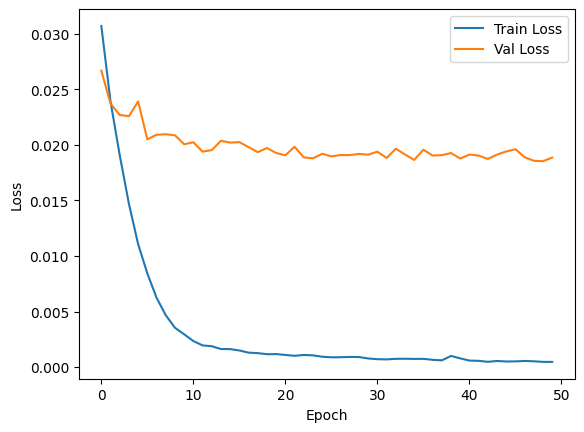

In [132]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

print(y_val_tensor)
# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Initialize the model, loss function, and optimizer
model = FCNN()
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []

n_epochs = 20

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Random Forest 

In [75]:
#Random Forest Classifier

#classifier funktioniert nicht, da dieser keine kontinuirlichen werte ausgeben kann. es geht nur ja / nein, und convertierung in ganze zahlen aber keine kommazahlen

from sklearn.ensemble import RandomForestClassifier
from sklearn import utils
#from sklearn import preprocessing

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(features, y, test_size=0.2)

forest_model = RandomForestClassifier(n_estimators=200)
y_train_ravel = []

for t_val in y_train:
    y_train_ravel.append(t_val[0])
    
# Convert y_train to a 1D array
y_train_ravel = np.ravel(y_train)    
y_val_ravel = np.ravel(y_val)


print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train_ravel.astype('float')))
print(y_train_ravel.astype('int'))
print(y_train_ravel)
forest_model.fit(X_train,y_train_ravel.astype('int'))

continuous
continuous
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

RandomForestClassifier(n_estimators=200)

In [73]:
forest_model.score(X_val, y_val_ravel.astype('int'))

1.0

## 5.3 RandomForestRegression Model

In [114]:
#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
# Split the dataset
forest_X_train, forest_X_val, forest_y_train, forest_y_val = train_test_split(features, y, test_size=0.2)

#create the model -> 10 trees
forest_model = RandomForestRegressor(n_estimators=100)


# Convert y_train to a 1D array
forest_y_train_ravel = np.ravel(forest_y_train)    
forest_y_val_ravel = np.ravel(forest_y_val)

#train the model
forest_model.fit(forest_X_train,forest_y_train)

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [115]:
forest_model.score(forest_X_val, forest_y_val)

#y_pred = forest_model.predict(X_val)

# Plot the results
#plt.figure(figsize=(10, 5))
#plt.scatter(forest_X_train, forest_y_train, c="k", label="data")
#plt.plot(forest_X_val, y_pred, c="g", label="prediction", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
#plt.title("Random Forest Regression")
#plt.legend()
#plt.show()

0.5537711156323297

## 5.4 KNeigborsRegresssion Model

In [98]:
from sklearn.neighbors import KNeighborsRegressor
# Split the dataset
neighbors_X_train, neighbors_X_val, neighbors_y_train, neighbors_y_val = train_test_split(features, y, test_size=0.2)

#create the model -> 10 neighbors
neighbors_model = KNeighborsRegressor(n_neighbors=1)

    
# Convert y_train to a 1D array
neighbors_y_train_ravel = np.ravel(neighbors_y_train)    
neighbors_y_val_ravel = np.ravel(neighbors_y_val)

#train the model
neighbors_model.fit(neighbors_X_train,neighbors_y_train)

KNeighborsRegressor(n_neighbors=1)

In [99]:
neighbors_model.score(neighbors_X_val, neighbors_y_val)

0.11783708460183606

## 5.5 GradientBoostingRegressor Model

In [112]:
from sklearn.ensemble import GradientBoostingRegressor
# Split the dataset
gradientBoosting_X_train, gradientBoosting_X_val, gradientBoosting_y_train, gradientBoosting_y_val = train_test_split(features, y, test_size=0.2)

#create the model -> 10 trees
gradientBoosting_model = GradientBoostingRegressor(n_estimators=100)

#gradientBoosting_y_train_ravel = []
#for t_val in gradientBoosting_y_train:
#    gradientBoosting_y_train_ravel.append(t_val[0])

#gradientBoosting_y_val_ravel = []
#for t_val in gradientBoosting_y_val:
#    gradientBoosting_y_val_ravel.append(t_val[0])
    
# Convert y_train to a 1D array
gradientBoosting_y_train_ravel = np.ravel(forest_y_train)    
gradientBoosting_y_val_ravel = np.ravel(forest_y_val)

#train the model
gradientBoosting_model.fit(gradientBoosting_X_train,gradientBoosting_y_train)

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor()

In [113]:
gradientBoosting_model.score(gradientBoosting_X_val, gradientBoosting_y_val)

0.18107133222438576

## DecisionTreeRegressor 

In [124]:
from sklearn.tree import DecisionTreeRegressor

# Split the dataset
decisionTree_X_train, decisionTree_X_val, decisionTree_y_train, decisionTree_y_val = train_test_split(features, y, test_size=0.2)

decisionTree = DecisionTreeRegressor(max_depth=300, random_state=5)
decisionTree.fit(decisionTree_X_train, decisionTree_y_train)

DecisionTreeRegressor(max_depth=300, random_state=5)

In [126]:
decisionTree.score(decisionTree_X_val, decisionTree_y_val)

0.23101196736399532